In [1]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import shutil
import random
from collections import defaultdict

# 1. Mount Google Drive (essential if in a new session)
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# 2. Define your original Pascal VOC dataset base path (source for images and annotations)
original_unzip_base_path = '/content/drive/My Drive/galapagos_seals_annotated_data/my_galapagos_seals_dataset'
original_annotations_dir = os.path.join(original_unzip_base_path, 'Annotations')

# Verify the original dataset path
if not os.path.exists(original_unzip_base_path):
    print(f"Error: Original dataset not found at {original_unzip_base_path}.")
    print("Please ensure the original dataset zip file is unzipped at /content/galapagos_seals_annotated_data/.")
    exit()

# 3. Define the ROOT directory for your NEW VGG16-specific HYBRID dataset on Google Drive
VGG16_DATA_ROOT_HYBRID = os.path.join('/content/drive/My Drive', 'vgg16_seals_classification_dataset_hybrid')

# 4. Define your class names (must match your dataset's class names in XMLs)
CLASS_NAMES = [
    "Arctocephalus_galapagoensis", # Minority class
    "Zalophus_wollebaeki"        # Majority class
]
MINORITY_CLASS = CLASS_NAMES[0]
MAJORITY_CLASS = CLASS_NAMES[1]

# 5. Define target image size (keeping it 224x224 for ResNet-50V2 compatibility)
TARGET_IMG_SIZE = (224, 224)

print(f"\nPreparing VGG16 HYBRID dataset for classes: {CLASS_NAMES}")
print(f"Cropped images will be resized to: {TARGET_IMG_SIZE}")
print(f"New dataset will be saved to: {VGG16_DATA_ROOT_HYBRID}")


# --- Cleanup previous HYBRID data if it exists for a fresh start ---
if os.path.exists(VGG16_DATA_ROOT_HYBRID):
    print(f"Cleaning up existing VGG16 hybrid data root: {VGG16_DATA_ROOT_HYBRID}")
    shutil.rmtree(VGG16_DATA_ROOT_HYBRID)
    print("Clean up complete.")
else:
    print(f"No existing hybrid dataset found at {VGG16_DATA_ROOT_HYBRID}. Proceeding with creation.")


# 6. Create necessary directories for the VGG16 classification dataset
for split_folder in ['train', 'val', 'test']:
    for class_name in CLASS_NAMES:
        os.makedirs(os.path.join(VGG16_DATA_ROOT_HYBRID, split_folder, class_name), exist_ok=True)
print("\nCreated VGG16 hybrid dataset structure on Drive.")


# Function to process and crop images for the HYBRID approach
def process_and_crop_dataset_hybrid(original_base_path, original_annotations_dir, vgg16_data_root_hybrid, class_names, target_size, minority_class, majority_class):
    split_map = {
        'train': 'train',
        'validation': 'val',
        'test': 'test'
    }

    total_final_class_counts = defaultdict(int)

    for original_split_name, vgg16_split_name in split_map.items():
        original_split_dir = os.path.join(original_base_path, original_split_name)
        vgg16_split_output_dir = os.path.join(vgg16_data_root_hybrid, vgg16_split_name)
        print(f"\nProcessing original '{original_split_name}' split for VGG16 '{vgg16_split_name}' (Hybrid)...")

        all_potential_crops_in_split = defaultdict(list)
        image_paths = []
        for class_subfolder in os.listdir(original_split_dir):
            class_subfolder_path = os.path.join(original_split_dir, class_subfolder)
            if os.path.isdir(class_subfolder_path):
                for img_name in os.listdir(class_subfolder_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_paths.append(os.path.join(class_subfolder_path, img_name))

        random.shuffle(image_paths) # Shuffle to ensure random selection of objects if multiple in image

        for image_path in image_paths:
            img_filename = os.path.basename(image_path)
            annotation_filename = os.path.splitext(img_filename)[0] + '.xml'
            annotation_filepath = os.path.join(original_annotations_dir, annotation_filename)

            if not os.path.exists(annotation_filepath):
                continue

            try:
                tree = ET.parse(annotation_filepath)
                root = tree.getroot()

                for obj in root.iter('object'):
                    label = obj.find('name').text
                    if label in class_names:
                        xml_box = obj.find('bndbox')
                        xmin = int(float(xml_box.find('xmin').text))
                        ymin = int(float(xml_box.find('ymin').text))
                        xmax = int(float(xml_box.find('xmax').text))
                        ymax = int(float(xml_box.find('ymax').text))

                        all_potential_crops_in_split[label].append({
                            'image_path': image_path,
                            'bbox': (xmin, ymin, xmax, ymax),
                            'label': label,
                            'original_filename': img_filename
                        })
            except Exception as e:
                print(f"  Error parsing annotation {annotation_filename}: {e}")

        # Determine hybrid target for this split: 2x minority count, but not more than original majority count
        minority_count_original_split = len(all_potential_crops_in_split[minority_class])
        majority_count_original_split = len(all_potential_crops_in_split[majority_class])

        # Define the target count for the majority class in the hybrid dataset
        # This will be the min of its original count or 2x the minority count
        hybrid_target_for_majority = min(majority_count_original_split, int(minority_count_original_split * 2.0)) # Using 2.0 as a factor

        print(f"  Minority class ('{minority_class}') count in '{original_split_name}': {minority_count_original_split}")
        print(f"  Majority class ('{majority_class}') original count in '{original_split_name}': {majority_count_original_split}")
        print(f"  Hybrid target for majority class in '{original_split_name}' (2x minority, capped by original): {hybrid_target_for_majority}")


        selected_crops_to_process = []
        selected_crops_to_process.extend(all_potential_crops_in_split[minority_class]) # Take all minority crops

        # Randomly select crops from the majority class up to the hybrid target
        random.shuffle(all_potential_crops_in_split[majority_class]) # Ensure random selection
        selected_crops_to_process.extend(all_potential_crops_in_split[majority_class][:hybrid_target_for_majority])

        random.shuffle(selected_crops_to_process) # Shuffle again to mix for saving

        processed_count_in_split = 0
        current_split_class_counts = defaultdict(int)

        # Perform cropping and saving for the selected crops
        for crop_info in selected_crops_to_process:
            try:
                img_path = crop_info['image_path']
                bbox = crop_info['bbox']
                label = crop_info['label']
                original_filename = crop_info['original_filename']

                img = Image.open(img_path).convert('RGB')
                xmin, ymin, xmax, ymax = bbox

                img_width, img_height = img.size
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(img_width, xmax)
                ymax = min(img_height, ymax)

                if not (xmin < xmax and ymin < ymax):
                    # print(f"  Warning: Invalid effective bounding box for {original_filename} label '{label}'. Skipping crop.")
                    continue

                cropped_img = img.crop((xmin, ymin, xmax, ymax))
                cropped_img_resized = cropped_img.resize(target_size, Image.Resampling.LANCZOS)

                output_dir_for_class = os.path.join(vgg16_split_output_dir, label)
                output_filename = f"{os.path.splitext(original_filename)[0]}_{label}_{random.randint(1000, 9999)}.jpg"
                output_path = os.path.join(output_dir_for_class, output_filename)
                cropped_img_resized.save(output_path)

                current_split_class_counts[label] += 1
                total_final_class_counts[label] += 1
                processed_count_in_split += 1
            except Exception as e:
                print(f"  Error processing image {crop_info['image_path']} for VGG16 hybrid: {e}")

        print(f"  Processed {processed_count_in_split} object instances for '{original_split_name}' split.")
        print(f"  Split distribution for '{original_split_name}': {dict(current_split_class_counts)}")


    print(f"\nTotal cropped images created for HYBRID VGG16 dataset: {sum(total_final_class_counts.values())}")
    print("Class distribution (HYBRID - total):")
    for cls, count in total_final_class_counts.items():
        print(f"  {cls}: {count} images")


# Run the data preparation process for hybrid
process_and_crop_dataset_hybrid(
    original_unzip_base_path,
    original_annotations_dir,
    VGG16_DATA_ROOT_HYBRID,
    CLASS_NAMES,
    TARGET_IMG_SIZE,
    MINORITY_CLASS,
    MAJORITY_CLASS
)

# --- Final Verification of the created dataset ---
print("\nVerifying HYBRID VGG16 dataset structure on Drive:")
for split_folder in ['train', 'val', 'test']:
    print(f"\n--- {split_folder} Split ---")
    for class_name in CLASS_NAMES:
        path = os.path.join(VGG16_DATA_ROOT_HYBRID, split_folder, class_name)
        if os.path.exists(path):
            num_files = len(os.listdir(path))
            print(f"  {class_name}: {num_files} images")
        else:
            print(f"  {class_name}: Path does not exist.")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!

Preparing VGG16 HYBRID dataset for classes: ['Arctocephalus_galapagoensis', 'Zalophus_wollebaeki']
Cropped images will be resized to: (224, 224)
New dataset will be saved to: /content/drive/My Drive/vgg16_seals_classification_dataset_hybrid
Cleaning up existing VGG16 hybrid data root: /content/drive/My Drive/vgg16_seals_classification_dataset_hybrid
Clean up complete.

Created VGG16 hybrid dataset structure on Drive.

Processing original 'train' split for VGG16 'train' (Hybrid)...
  Minority class ('Arctocephalus_galapagoensis') count in 'train': 38
  Majority class ('Zalophus_wollebaeki') original count in 'train': 341
  Hybrid target for majority class in 'train' (2x minority, capped by original): 76
  Processed 114 object instances for 'train' split.
  Split distribution for 'train': {'Zalophus_w

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!

Training ResNet-50V2 model on HYBRID data for 2 classes: ['Arctocephalus_galapagoensis', 'Zalophus_wollebaeki']
Using dataset from: /content/drive/My Drive/vgg16_seals_classification_dataset_hybrid
Cropped images resized to: (224, 224)
Found 114 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
Found 15 images belonging to 2 classes.

Data generators created.
Found 114 training images belonging to 2 classes.
Found 12 validation images belonging to 2 classes.
Found 15 test images belonging to 2 classes.

Calculating class weights...
Calculated Class Weights: {0: np.float64(1.5), 1: np.float64(0.75)}
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 49,255,682 (187.90 MB)

 Trainable params: 25,690,882 (98.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)


Starting ResNet-50V2 model training (Hybrid Case)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5652 - loss: 3.9183
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_hybrid_case/best_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5661 - loss: 3.8992 - val_accuracy: 0.6667 - val_loss: 1.9602 - learning_rate: 1.0000e-04
Epoch 2/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 1.0000 - loss: 3.5973e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.66667
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 1.0000 - loss: 3.5973e-04 - val_accuracy: 0.6667 - val_loss: 1.8490 - learning_rate: 1.0000e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7466 - loss: 2.4357
Epoch 3: val_accuracy improved from 0.66667 to 0.83333, saving model to /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_hybrid_case/best_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7481 - loss: 2.4089 - val_accuracy: 0.8333 - val_loss: 1.7006 - learning_rate: 1.0000e-04
Epoch 4/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 26s 996ms/step - accuracy: 0.5000 - loss: 1.8907
Epoch 4: val_accuracy did not improve from 0.83333
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5000 - loss: 1.8907 - val_accuracy: 0.8333 - val_loss: 1.7021 - learning_rate: 1.0000e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8316 - loss: 1.8113
Epoch 5: val_accuracy did not improve from 0.83333
28/28 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8324 - loss: 1.7950 - val_accuracy: 0.7500 - val_loss: 2.2959 - learning_rate: 1.0000e-04
Epoch 6/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5000 - loss: 8.5519
Epoch 6: val_accuracy did not improve from 0.83333
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.5000 - loss: 8.5519 - val_accuracy: 0.8333 - val_loss: 2.4913 - learning_rate: 1.0000e-04
Epoch 7/50
28/28 ━

28/28 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9332 - loss: 0.7267 - val_accuracy: 0.9167 - val_loss: 1.3522 - learning_rate: 2.0000e-05
Epoch 14/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7500 - loss: 0.2896
Epoch 14: val_accuracy did not improve from 0.91667
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7500 - loss: 0.2896 - val_accuracy: 0.9167 - val_loss: 1.3463 - learning_rate: 2.0000e-05
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9314 - loss: 0.4381
Epoch 15: val_accuracy did not improve from 0.91667
28/28 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9309 - loss: 0.4411 - val_accuracy: 0.9167 - val_loss: 1.2055 - learning_rate: 2.0000e-05
Epoch 16/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 26s 994ms/step - accuracy: 0.7500 - loss: 0.7728
Epoch 16: val_accuracy did not improve from 0.91667
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7500 - loss: 0.7728 - val_accuracy: 0.9167 - val_loss: 1.2215 - learning_rate: 2.0000e-05
Epoch 17/50
2

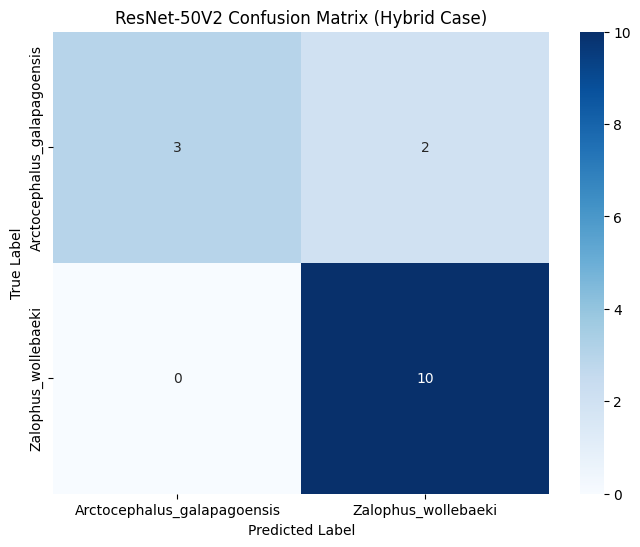

Confusion matrix plot saved to: /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_hybrid_case/confusion_matrix.png
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7917 - loss: 1.4763

Overall Test Loss: 1.2379
Overall Test Accuracy: 0.8333


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight # For calculating class weights

# 1. Mount Google Drive (essential if in a new session)
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# 2. Define the ROOT directory for your HYBRID dataset on Google Drive
# This is the NEW path pointing to the balanced data.
HYBRID_DATA_ROOT = os.path.join('/content/drive/My Drive', 'vgg16_seals_classification_dataset_hybrid')

# Verify that the dataset exists
if not os.path.exists(HYBRID_DATA_ROOT):
    print(f"Error: Hybrid dataset not found at {HYBRID_DATA_ROOT}.")
    print("Please ensure the 'Step 1: Prepare the Hybrid Dataset' cell was run successfully.")
    exit()

# 3. Define dataset paths for training, validation, and test splits
TRAIN_DIR_HYBRID = os.path.join(HYBRID_DATA_ROOT, 'train')
VAL_DIR_HYBRID = os.path.join(HYBRID_DATA_ROOT, 'val')
TEST_DIR_HYBRID = os.path.join(HYBRID_DATA_ROOT, 'test')

# 4. Define your class names
CLASS_NAMES = [
    "Arctocephalus_galapagoensis", # Minority class
    "Zalophus_wollebaeki"        # Majority class
]
NUM_CLASSES = len(CLASS_NAMES)
TARGET_IMG_SIZE = (224, 224) # ResNet50V2's common input size
BATCH_SIZE = 4 # Use a smaller batch size given the reduced dataset

print(f"\nTraining ResNet-50V2 model on HYBRID data for {NUM_CLASSES} classes: {CLASS_NAMES}")
print(f"Using dataset from: {HYBRID_DATA_ROOT}")
print(f"Cropped images resized to: {TARGET_IMG_SIZE}")


# 5. Data Generators with Augmentation (for training) and Preprocessing
# Apply augmentation for both classes, as it's generally beneficial
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_HYBRID,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR_HYBRID,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_HYBRID,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

print("\nData generators created.")
print(f"Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
print(f"Found {val_generator.samples} validation images belonging to {val_generator.num_classes} classes.")
print(f"Found {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")

# --- Calculate Class Weights ---
# Still crucial for the "increment" part of the hybrid strategy
print("\nCalculating class weights...")
train_labels = train_generator.classes
class_weights_dict = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: class_weights_dict[i] for i in range(len(class_weights_dict))}
print(f"Calculated Class Weights: {class_weights_dict}")


# 6. Build the ResNet-50V2 Model for Transfer Learning
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(TARGET_IMG_SIZE[0], TARGET_IMG_SIZE[1], 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 7. Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 8. Define Callbacks for training
model_checkpoint_path_hybrid = os.path.join( # New path for this experiment
    '/content/drive/My Drive',
    'vgg16_training_results',
    'resnet50v2_classification_hybrid_case', # Specific subfolder for hybrid
    'best_model.h5'
)
os.makedirs(os.path.dirname(model_checkpoint_path_hybrid), exist_ok=True)

checkpoint = ModelCheckpoint(
    model_checkpoint_path_hybrid,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=0.000001,
    mode='max',
    verbose=1
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

# 9. Train the Model
EPOCHS_HYBRID = 50

print("\nStarting ResNet-50V2 model training (Hybrid Case)...")
history_hybrid = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_HYBRID,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list,
    class_weight=class_weights_dict # <-- CRUCIAL for hybrid strategy
)

print("\nResNet-50V2 Training (Hybrid Case) complete!")
print(f"Best model saved to: {model_checkpoint_path_hybrid}")

# Save training history
history_hybrid_dict = history_hybrid.history
history_filepath_hybrid = os.path.join(os.path.dirname(model_checkpoint_path_hybrid), 'training_history.json')
with open(history_filepath_hybrid, 'w') as f:
    json.dump(history_hybrid_dict, f)
print(f"Training history saved to: {history_filepath_hybrid}")


# --- 10. Evaluate on test set and get more metrics ---
print("\nEvaluating model on the test set for detailed metrics...")

Y_pred_proba_hybrid = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + (test_generator.samples % BATCH_SIZE != 0))
Y_pred_classes_hybrid = np.argmax(Y_pred_proba_hybrid, axis=1)

Y_true_hybrid = test_generator.classes[test_generator.index_array]

print("\n--- ResNet-50V2 Classification Report (Hybrid Case) ---")
report_hybrid = classification_report(Y_true_hybrid, Y_pred_classes_hybrid, target_names=CLASS_NAMES)
print(report_hybrid)

# Save Classification Report to Drive
report_filepath_hybrid = os.path.join(os.path.dirname(model_checkpoint_path_hybrid), 'classification_report.txt')
with open(report_filepath_hybrid, 'w') as f:
    f.write(report_hybrid)
print(f"Classification report saved to: {report_filepath_hybrid}")

print("\n--- ResNet-50V2 Confusion Matrix (Hybrid Case) ---")
cm_hybrid = confusion_matrix(Y_true_hybrid, Y_pred_classes_hybrid)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet-50V2 Confusion Matrix (Hybrid Case)')
plt.show()

# Save Confusion Matrix plot to Drive
cm_filepath_hybrid = os.path.join(os.path.dirname(model_checkpoint_path_hybrid), 'confusion_matrix.png')
plt.savefig(cm_filepath_hybrid)
print(f"Confusion matrix plot saved to: {cm_filepath_hybrid}")
plt.close()


overall_test_loss_hybrid, overall_test_accuracy_hybrid = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"\nOverall Test Loss: {overall_test_loss_hybrid:.4f}")
print(f"Overall Test Accuracy: {overall_test_accuracy_hybrid:.4f}")